# 심화 학습 : 가우스 혼합 모델

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## GMM 등장 배경 : K-평균의 약점

In [2]:
# 데이터 생성
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples = 400, centers = 4, cluster_std = 0.60, random_state = 0)
X = X[:, ::-1]

C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


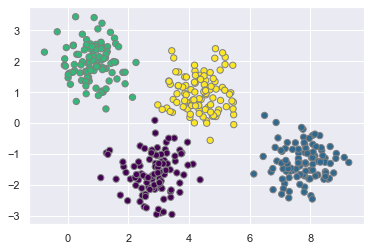

In [3]:
# K-평균 레이블로 데이터를 플로팅
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state = 0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c = labels, s = 40, cmap = 'viridis', edgecolor = 'gray')

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters = 4, rseed = 0, ax = None):
    labels = kmeans.fit_predict(X)
    
    # 입력 데이터 플로팅
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c = labels, s = 40, cmap = 'viridis', zorder = 2, edgecolor = 'gray')
    
    # K-평균 모델 표시
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc = '#CCCCCC', lw = 3, alpha = 0.5, zorder = 1))

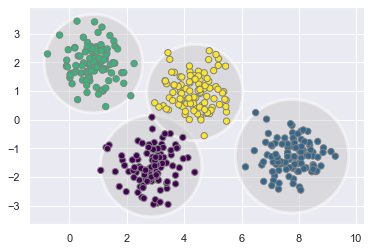

In [5]:
kmeans = KMeans(n_clusters = 4, random_state = 0)
plot_kmeans(kmeans, X)

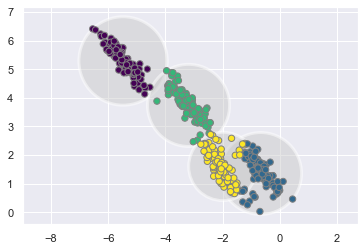

In [6]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters = 4, random_state = 0)
plot_kmeans(kmeans, X_stretched)

## E-M 단계 일반화하기 : 가우스 혼합 모델

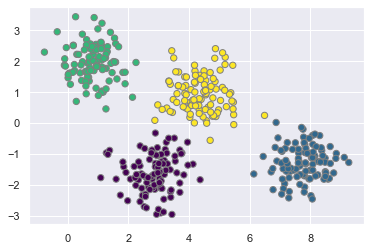

In [7]:
from sklearn.mixture import GaussianMixture as GMM

gmm = GMM(n_components = 4, random_state = 0).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c = labels, s = 40, cmap = 'viridis', edgecolor = 'gray')

In [8]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.469 0.    0.531]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


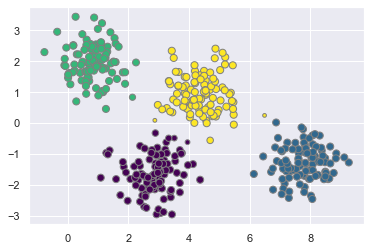

In [9]:
size = 50 * probs.max(1) ** 2 # 제곱으로 차이를 강조
plt.scatter(X[:, 0], X[:, 1], c = labels, cmap = 'viridis', s = size, edgecolor = 'gray')

##### <b>내부적으로 가우스 혼합 모델은 K-평균과 비슷하다. 이 모델 역시 질적으로 다음 작업을 수행하는 기댓값-최대화 방식을 사용한다.</b>
1. 위치와 모양을 예측한다.
2. 소렴될 때까지 다음 단계를 반복한다.
    * E-단계 : 각 점에 대해 각 군집의 일원일 가능성을 인코딩한 가중치를 구한다.
    * M-단계 : 모든 데이터 점을 기반으로 가중치를 사용해 각 군집의 위치, 정규화, 모양을 업데이트한다.

In [10]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax = None, **kwargs):
    ''' 주어진 위치와 공분산으로 타원 그리기'''
    ax = ax or plt.gca()
    
    # 공분산을 주축으로 전환
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
        
    # 타원 그리기
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

In [11]:
def plot_gmm(gmm, X, label = True, ax = None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    
    if label:
        ax.scatter(X[:, 0], X[:, 1], c = labels, s = 40, cmap = 'viridis', zorder = 2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s = 40, zorder = 2)
    
    ax.axis('equal')
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha = w * w_factor)

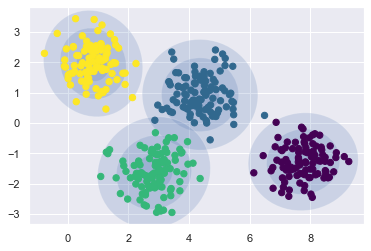

In [12]:
gmm = GMM(n_components = 4, random_state = 42)
plot_gmm(gmm, X)

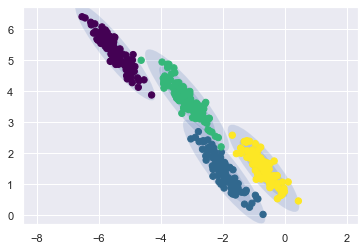

In [13]:
gmm = GMM(n_components = 4, covariance_type = 'full', random_state = 42)
plot_gmm(gmm, X_stretched)

### 공분산 유형 선택하기

1. covariance_type = 'diag'
    * 각 차원에 따라 군집의 크기를 독립적으로 설정할 수 있고, 결과로 얻은 타원은 축을 따라 정렬된다.<br><br>
2. covariance_type = 'spherical'
    * 군집의 모양을 모든 차원이 동일하도록 제한한다. 결과로 얻은 군집은 K-평균과 완전히 똑같지는 않지만, 비슷한 특징을 가지게 된다.<br><br>
3. covariance_type = 'full'
    * 각 군집이 임의의 방향을 가지는 타원형으로 모델링되게 한다.

## 밀도 추정에 GMM 사용하기

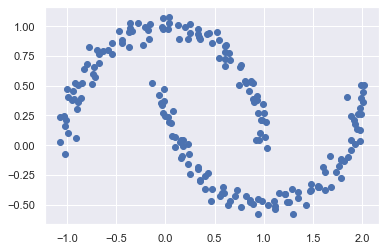

In [14]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise = .05, random_state = 0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1])

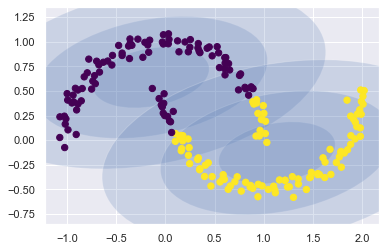

In [15]:
gmm2 = GMM(n_components = 2, covariance_type = 'full', random_state = 0)
plot_gmm(gmm2, Xmoon)

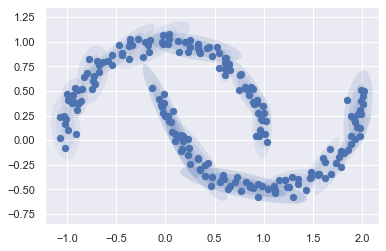

In [16]:
gmm16 = GMM(n_components = 16, covariance_type = 'full', random_state = 0)
plot_gmm(gmm16, Xmoon, label = False)

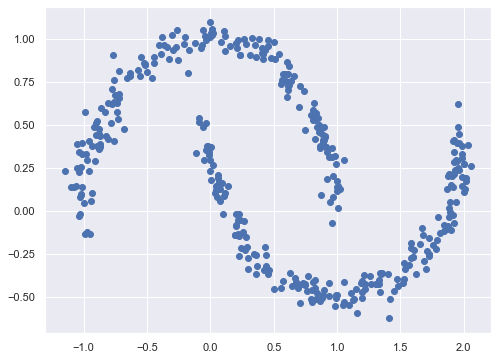

In [17]:
Xnew, ynew = gmm16.sample(400)
plt.figure(figsize = (8, 6))
plt.scatter(Xnew[:, 0], Xnew[:, 1])

### 얼마나 많은 성분을 사용할 것인가?

Text(0.5, 0, 'n_components')

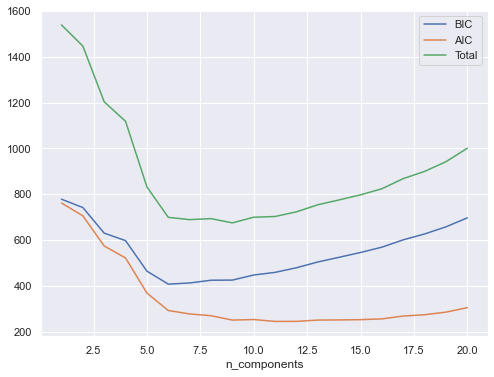

In [18]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type = 'full', random_state = 0).fit(Xmoon) for n in n_components]

plt.figure(figsize = (8, 6))
plt.plot(n_components, [m.bic(Xmoon) for m in models], label = 'BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label = 'AIC')
plt.plot(n_components, [x+y for x, y in zip([m.aic(Xmoon) for m in models], [m.bic(Xmoon) for m in models])]  , label = 'Total')
plt.legend(loc = 'best')
plt.xlabel('n_components')

## 예제 : 새로운 데이터를 생성하는 GMM

In [19]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [20]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize = (8, 8), subplot_kw = dict(xticks = [], yticks = []))
    fig.subplots_adjust(hspace = 0.05, wspace = 0.05)
    
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap = 'binary')
        im.set_clim(0, 16)

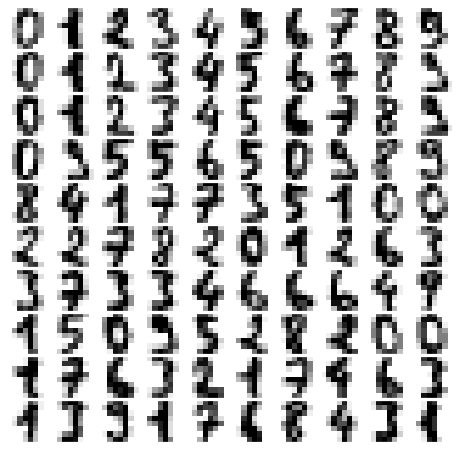

In [21]:
plot_digits(digits.data)

In [22]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten = True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

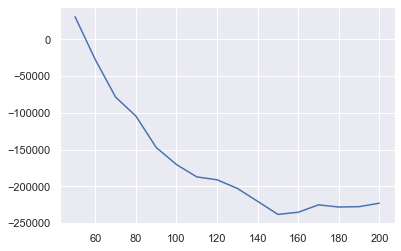

In [23]:
n_components = np.arange(50, 210, 10)
models = [GMM(n, covariance_type = 'full', random_state = 0) for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics)

In [24]:
gmm = GMM(110, covariance_type = 'full', random_state = 0)
gmm.fit(data)
print(gmm.converged_)

True


In [25]:
data_new, _ = gmm.sample(100)
data_new.shape

(100, 41)

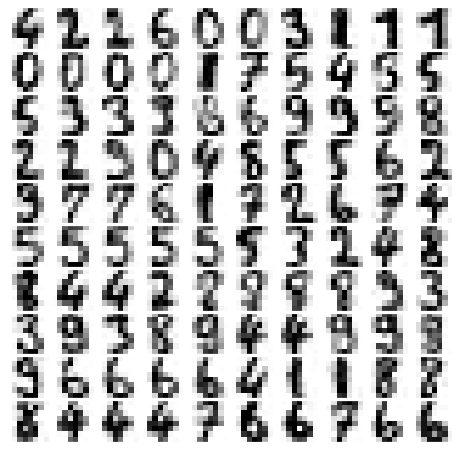

In [26]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)